In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Lecture: Hypothesis Testing

**Question: Do smoking mothers have babies with lower birthweight?**

In [2]:
births = Table.read_table('baby.csv')

In [3]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [4]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [5]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


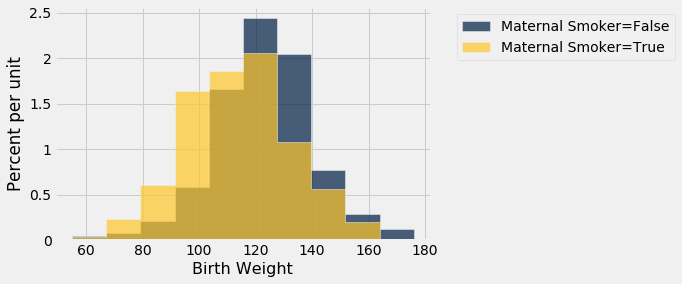

In [6]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [7]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


**Question: Do smoking mothers have babies with lower birthweight?**

Hypotheses in words:

$H_0$: Smoking mothers do not have babies with lower mean birthweights. That is, smoking mothers and non-smoking mothers have babies with the same mean birthweights.

$H_A$: Smoking mothers have babies with lower mean birthweights.

Hypotheses in symbols:

$H_0: \mu_s = \mu_n$ or $\mu_s - \mu_n = 0$

$H_A: \mu_s < \mu_n$ or $\mu_s - \mu_n < 0$

In [10]:
means = means_table.column(1)
print(means)
observed_difference = means.item(1) - means.item(0)
observed_difference

[123.08531469 113.81917211]


-9.266142572024918

In [12]:
def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [13]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

### Shuffles: Simulation Under Null Hypothesis ###

In [14]:
smoking_and_birthweight.show(5)

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136


In [29]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')
shuffled_labels

array([ True,  True,  True, ..., False,  True,  True])

In [30]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

In [31]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,True
True,128,True
True,108,True
False,136,True
False,138,False
False,132,True
False,120,False
True,143,False
False,140,False


In [32]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.9397534926946634

In [33]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

### Permutation Test ###

In [34]:
def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

In [65]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

2.2275637216813777

In [47]:
differences = make_array()

for i in np.arange(5000):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


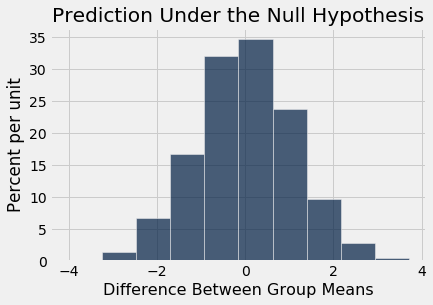

In [48]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

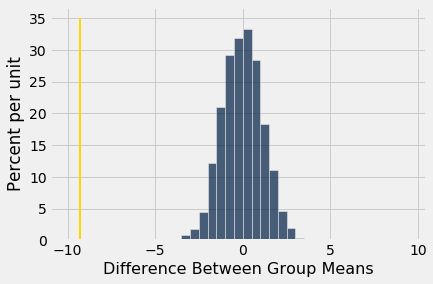

In [46]:
Table().with_column('Difference Between Group Means', differences).hist(bins = np.arange(-10,10,.5))
plots.plot(make_array(observed_difference, observed_difference), make_array(0, 0.35), color='gold', lw=2)

In [49]:
differences

array([-0.33017048,  0.64284169,  0.63926444, ...,  0.1205631 ,
       -0.01537243, -1.99359203])

In [50]:
observed_difference

-9.266142572024918

In [59]:
# Calculating p value
# One-sided less than
sum(differences < observed_difference) / len(differences)

In [59]:
# One-sided greater than
sum(differences > observed_difference) / len(differences)

1.0

In [60]:
# Two-sided
sum(differences < observed_difference) / len(differences) * 2

0.0

In [54]:
len(differences)

5000